In [1]:
import numpy as np
from pathlib import Path
import lmdb
import six
from PIL import Image
import matplotlib.pyplot as plt
from tqdm import tqdm
import japanize_matplotlib
import json
import cv2
from pprint import pprint

In [64]:
ROOT_DIR = Path('../../../')
LMDB_DIR = ROOT_DIR / 'data/data0008/lmdb'

CHART_TYPES = [
    'scatter',
    'line',
    'vertical_bar',
    'horizontal_bar',
    'scatter-line'
]

In [65]:
env = lmdb.open(str(LMDB_DIR), max_readers=32,
                readonly=True, lock=False, readahead=False, meminit=False)
with env.begin(write=False) as txn:
    n_samples = int(txn.get('num-samples'.encode()))

In [66]:
scatter_indices = []
for idx in tqdm(range(n_samples), total=n_samples):
    with env.begin(write=False) as txn:
        # load json
        label_key = f'label-{str(idx+1).zfill(8)}'.encode()
        label = txn.get(label_key).decode('utf-8')
    json_dict = json.loads(label)

    if json_dict['chart-type'] != 'scatter':
        continue
    scatter_indices.append(idx)

100%|██████████| 1510/1510 [00:00<00:00, 6040.66it/s]


In [73]:
def idx2data(i):
    idx = scatter_indices[i]
    with env.begin(write=False) as txn:
        # load json
        label_key = f'label-{str(idx+1).zfill(8)}'.encode()
        label = txn.get(label_key).decode('utf-8')
        # load image
        img_key = f'image-{str(idx+1).zfill(8)}'.encode()
        imgbuf = txn.get(img_key)
    buf = six.BytesIO()
    buf.write(imgbuf)
    buf.seek(0)
    json_dict = json.loads(label)
    img = np.array(Image.open(buf).convert('RGB'))
    h, w, _ = img.shape

    keypoints = []
    print(len(json_dict['data-series']))
    for visual_elements in json_dict['visual-elements']['scatter points']:
        for dic in visual_elements:
            x, y = dic['x'], dic['y']
            if x < 0 or y < 0 or x > w or y > h:
                continue
            keypoints.append([x, y])
    return img, keypoints

In [74]:
def plot_img(i):
    img, keypoints = idx2data(i)
    img_draw = img.copy()
    for x, y in keypoints:
        cv2.circle(img_draw, (int(x), int(y)), 5, (0, 0, 0), -1)
    plt.imshow(img_draw)
    plt.show()

11


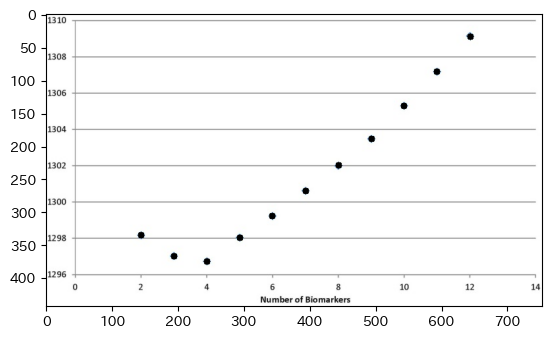

In [81]:
plot_img(342)

In [41]:
img, keypoints = idx2data(2)

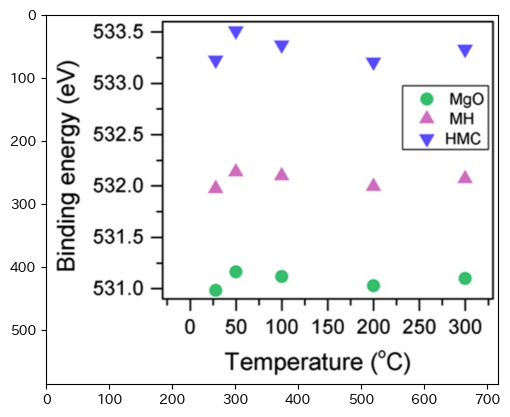

In [42]:
plt.imshow(img)